# Phase 1 (Preprocessing a qr code before decoding)

## Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode

## Plotting all the test cases and their histograms

In [ ]:
# Function to plot all the test cases and their histograms
def plot_all_test_cases(image_path, number):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Test case {number}')
    plt.axis('off')

    # Plot the histogram
    plt.subplot(1, 2, 2)
    plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Grayscale Histogram')

    # Show the plot
    plt.tight_layout()
    plt.show()

# # List of QR code image paths
qr_images = [
    'images/01-Getting-started.png', 'images/02-Matsawar-3edel-ya3am.png','images/03-Leffy-bina-ya-donya.png', 'images/04-Black-mirror.png','images/05-Caesar-cipher.png','images/06-Railfence-cipher.png', 'images/07-THE-MIGHTY-FINGER.png', 'images/08-Compresso-Espresso.png','images/09-My-phone-fell-while-taking-this-one-...-or-did-it.png', 'images/10-Gone-With-The-Wind.png', 'images/11-weewooweewooweewoo.png', 'images/12-mal7-w-felfel.png', 'images/13-2el-noor-2ata3.png', 'images/14-BANANAAA!!!.png', 'images/15-beast-mode-computer-vision-(this-one-is-from-wikipedia).jpg', 'images/16-V3-QR-Code...-can-you-do-it.png'
             ]

# Plot each QR code and its histogram
count = 1
for qr_image in qr_images:
    plot_all_test_cases(qr_image, count)
    count = count + 1


## Defining general functions to use in all code

### Global Variable

In [9]:
# Base Centroid #
# Holds the centroid of the first image as a refrence
base_centroid = None

### Plotting functions

In [3]:
# Function to read an image and plot its histogram
def plot_image_and_histogram(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('QR Code Image')
    plt.axis('off')

    # Plot the histogram
    plt.subplot(1, 2, 2)
    plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Grayscale Histogram')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Function to take a dictionary of images and plot them and their histograms
def plot_all_needed_images(dict_img):
    # iterating through the dictionary and plotting each needed image along with it's histogram
    for key in dict_img:
        img = dict_img[key]
        # Plot the image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{key}')
        plt.axis('off')

        # Plot the histogram
        plt.subplot(1, 2, 2)
        plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.title('Grayscale Histogram')

        # Show the plot
        plt.tight_layout()
        plt.show()

### Finding centroid of shapes

In [4]:
def find_centroid(contour):
    # Finds the centroid of a contour #
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx,cy

### Rotation functions

In [5]:
def find_point_with_yMax (cont):
    # Finding the bottom right point #
    max_y = 0
    max_point = None
    for point in cont:
        if point[0] > max_y:
            max_y = point[0]
            max_point = point
    return max_point
def find_point_with_xMminYMax (cont):
    # Finding the top right point #
    min_x = 9999
    min_points = []
    for point in cont:
        if point[1] <= min_x:
            min_x = point[1]
            min_points.append(point) 
    return find_point_with_yMax(min_points)
def find_angle(vec):
    #Find angle between the vector and the y-axis#
    y_axis = np.array([0, 1])

    # Calculate the dot product
    dot_product = np.dot(vec, y_axis)

    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vec)
    magnitude2 = np.linalg.norm(y_axis)

    # Calculate the cosine of the angle between the 2 lines
    cosine_angle = dot_product / (magnitude1 * magnitude2)

    # Calculate the angle in degrees
    return (np.arccos(cosine_angle) * 180 / np.pi)
def rotate_img_clockwise(img, angle):
    h,w = img.shape[:2]
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((w / 2, h / 2), -angle, 1)
    # Perform the rotation
    return (cv2.warpAffine(img, rotation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255)))

### Getting Hough lines

In [6]:
def get_hough(img):
    # Find the Hough transfrom of the image #
    
    # Apply Canny edge detection 
    edges = cv2.Canny(img, 50, 150)
    # Apply Hough transfrom
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=50, maxLineGap=190)
    # Draw Hough lines on a black mask and return it
    mask = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return mask

### Getting Contour

In [7]:
def get_contour(houghImg):
    # Find the exact and approximate contour of the qr code #

    # Find contours in the hough image
    contours, _ = cv2.findContours(houghImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Filter contours that have 4 edge points and max area
    max_area = 0
    selected_contour_exact = None
    selected_contour_appx = None

    for contour in contours:
        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  
            # Calculate the area of the contour
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                selected_contour_exact = contour
                selected_contour_appx = approx
    return (selected_contour_exact, selected_contour_appx)

### Shifting perspective

In [8]:
def shift_perspective(img, contour, target_verticies):

    h,w = img.shape[:2]
    
    #   Original verticies from the contour
    bottom_left, top_left, top_right, bottom_right = contour.reshape(-1, 2)
    original_verticies = np.array([bottom_left, top_left, top_right, bottom_right], dtype= np.float32)

    # Apply prespective transfrom
    perspective_transform_matrix = cv2.getPerspectiveTransform(original_verticies, target_verticies)
    return (cv2.warpPerspective(img, perspective_transform_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255)))

### Translation functions

In [10]:
def translate_to_middle(img, contour, tolerance_x=0, tolerance_y=0):
    # Translate the image to the middle of the frame #

    # Centroid of base image is right at the middle, Whiler Centroid of the #
    # current image is not, thus tolerance is added to correct this difference # 

    h,w = img.shape[:2]
    # Find img centroid
    old_centroid = find_centroid(contour=contour)
    # Find the translation matrix to the base centroid
    tx = base_centroid[0] - old_centroid[0] + tolerance_x
    ty = base_centroid[1] - old_centroid[1] + tolerance_y
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    # Translate the image
    return (cv2.warpAffine(img, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255)))

## Test cases

### Test case 01

#### What this case needs?
* Case 01 is a clean and correctly aligned so we can compare it and its histogram to the rest of the test cases.

#### What was done?
* Here we used our 'get_contour' function to detect the outer outline around the qr code.

#### What could be improved?
* Currently this case is already ready for decoding

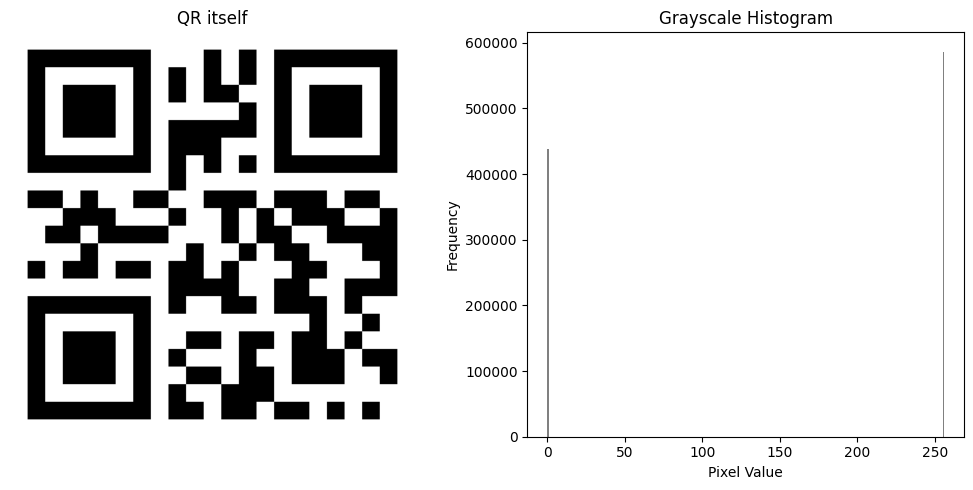

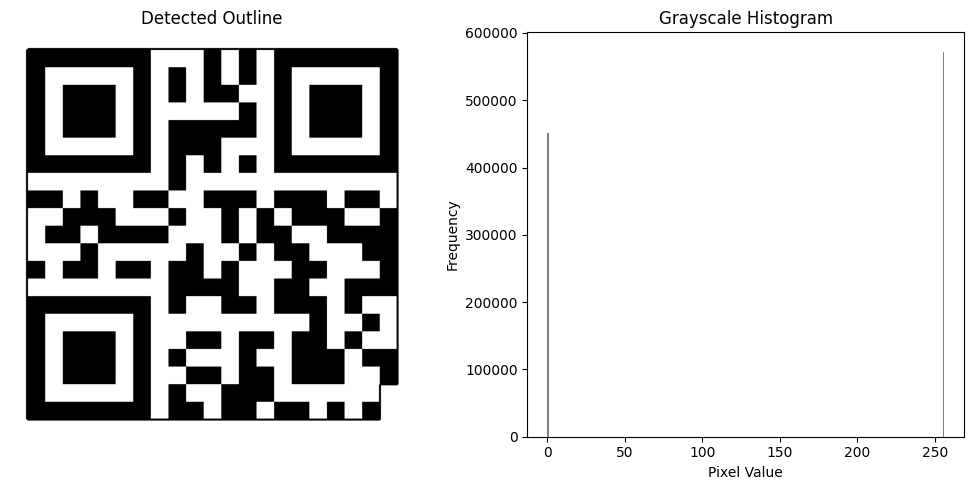

In [31]:
# Testcase 1 #
def tc01_preprocessing(original_img):
    
    # Find hough
    hough_lines_1 = get_hough(original_img)
    # Find contours
    exact,appx = get_contour(hough_lines_1)
    # Find base centroid
    global base_centroid
    base_centroid = find_centroid(exact)
    # Draw contour
    cont_img = original_img.copy()
    if exact is not None:
        cv2.drawContours(cont_img, [exact], -1, (0, 0, 0), 4)
    # Construnct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
    }
    return printing_dict

img_1 = cv2.imread('images/01-Getting-started.png', cv2.IMREAD_GRAYSCALE)
dict_1 = tc01_preprocessing(img_1)
plot_all_needed_images(dict_1)

### Test case 02

#### What this case needs?
* Case 02 is a bit messy.
* First, it is rotated at an agle we are yet to deduce.
* Second, it is cut short so we have a significant amount of data that maybe lost.
* This case needs to be rotated, translated to the right, and it needs to have it finder pattern filled.

#### What was done?
* Here we detected the outline.
* Then we rotated the image.
* Then we translated the image to the right.

#### What could be improved?
* This case is yet to be filled so we can have an appropriate finder pattern.

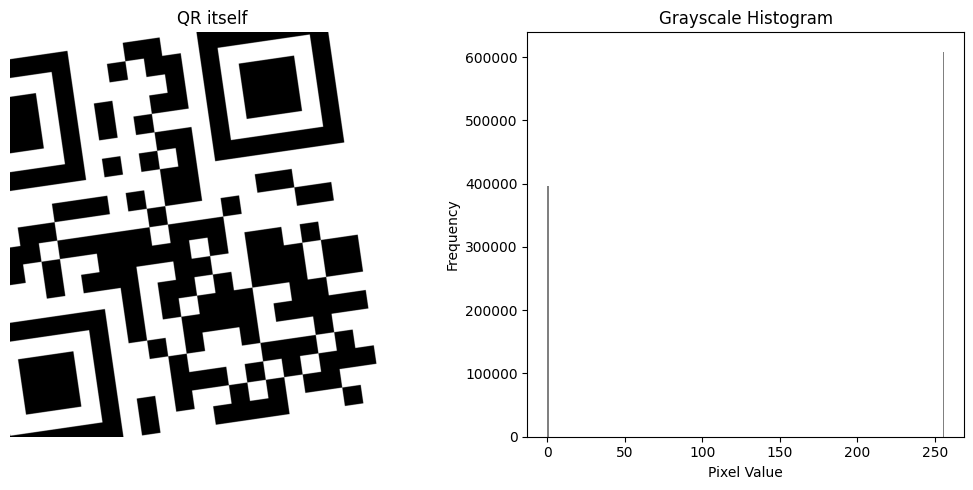

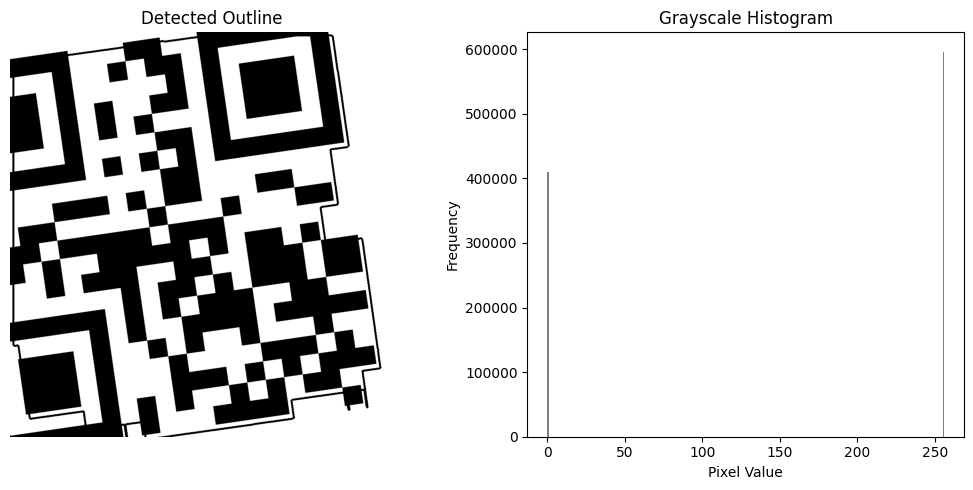

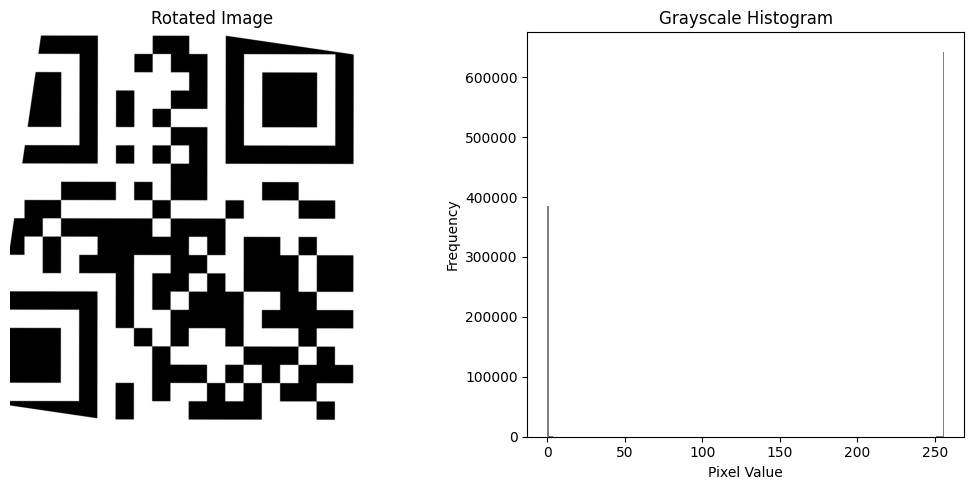

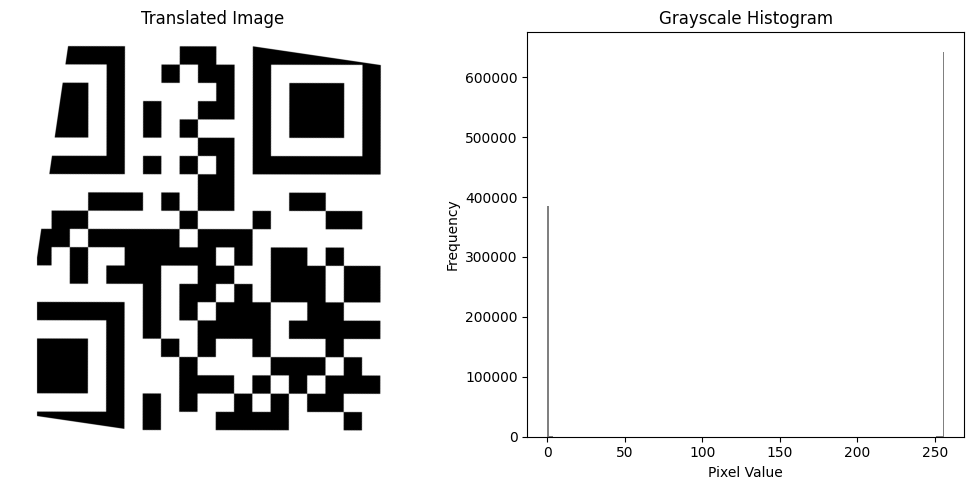

In [32]:
# Testcase 2 #
def tc02_preprocessing(original_img):
    
    # Pad the image so we can draw complete lines in the hough transform
    padding = 10
    padded_img = cv2.copyMakeBorder(original_img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=(255,255,255))
    # Find Hough
    hough_lines_2 = get_hough(padded_img)
    # Find Contour
    exact,appx = get_contour(hough_lines_2)
    # Draw contour
    cont_img = original_img.copy()
    if exact is not None:
        cv2.drawContours(cont_img, [exact], -1, (0, 0, 0), 4)
    # Find angle between contour side and y-axis 
    p1 = find_point_with_xMminYMax(exact.reshape(-1, 2))
    p2 = find_point_with_yMax(exact.reshape(-1, 2))
    vector = p2-p1
    angle = find_angle(vector) # 8.38 degrees
    # Rotate the image
    rotated_img = rotate_img_clockwise(padded_img, angle)
    # Translate the image
    translated_img = translate_to_middle(rotated_img, exact, tolerance_y= 30)
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'Rotated Image' : rotated_img,
        'Translated Image' : translated_img
    }
    return printing_dict

img_2 = cv2.imread('./images/02-Matsawar-3edel-ya3am.png', cv2.IMREAD_GRAYSCALE)
dict_2 = tc02_preprocessing(img_2)
plot_all_needed_images(dict_2)

### Test case 03

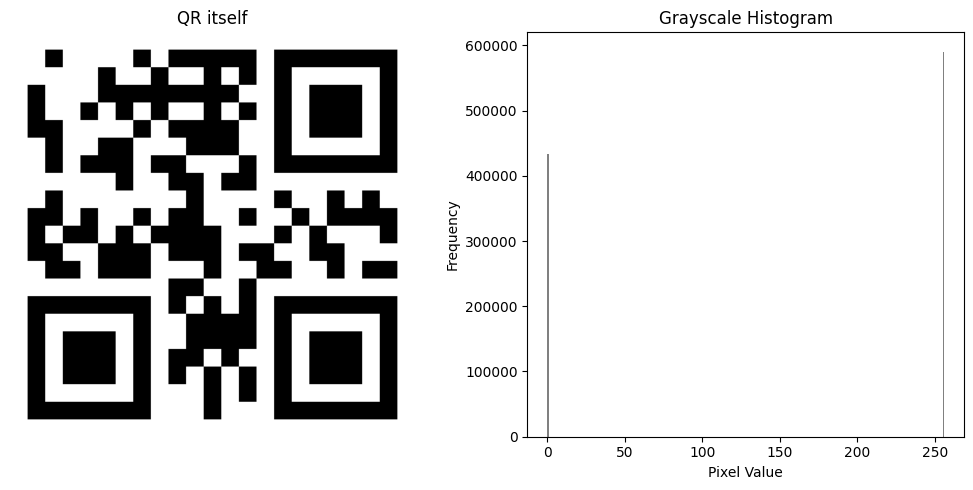

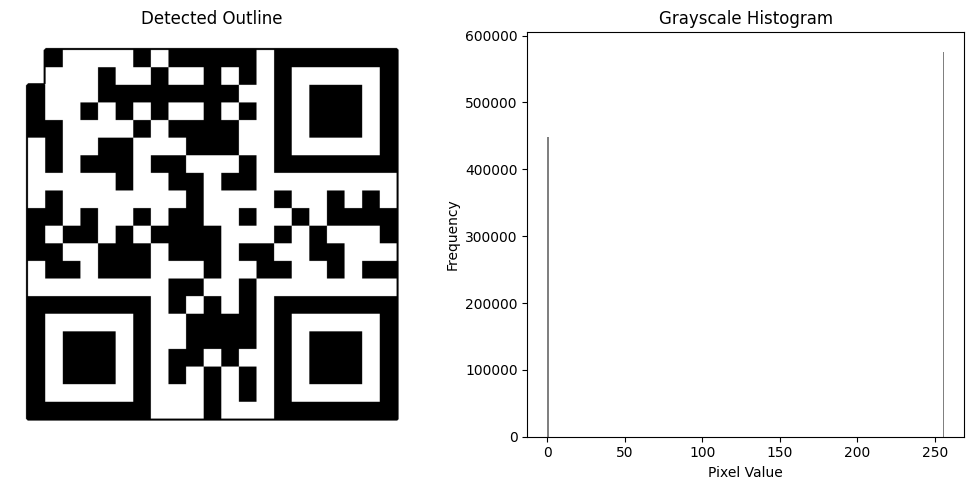

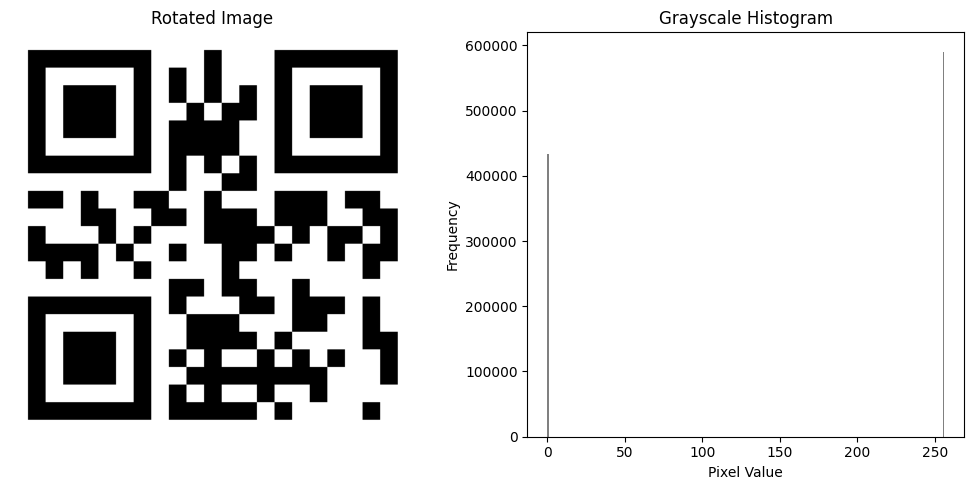

In [13]:
# Testcase 3 #
def tc03_preprocessing(original_img):
    
    # Reading the original image
    img = cv2.imread('images/03-Leffy-bina-ya-donya.png')
    # Find Hough
    hough_lines_3 = get_hough(original_img)
    # Find Contour
    exact,appx = get_contour(hough_lines_3)
    # Draw contour
    cont_img = original_img.copy()
    if exact is not None:
        cv2.drawContours(cont_img, [exact], -1, (0, 0, 0), 4) 
    # Rotate image
    rotated_img = rotate_img_clockwise(original_img, 180)
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'Rotated Image' : rotated_img
    }
    return printing_dict
    
img_3 = cv2.imread('./images/03-Leffy-bina-ya-donya.png', cv2.IMREAD_GRAYSCALE)
dict_3 = tc03_preprocessing(img_3)
plot_all_needed_images(dict_3)

### Test case 04

In [ ]:
# Function to invert the colors of an image
def invert_and_threshold(img):
    # Invert the colors by subtracting each pixel's value from 255 (assuming it's a grayscale image)
    inverted_img = 255 - img

    _, thresholded_img = cv2.threshold(inverted_img, 200, 255, cv2.THRESH_BINARY)

    return thresholded_img

def tc04_preprocessing(img):
    inverted_thresholded_img = invert_and_threshold(img)

    rotated_image = rotate_img_clockwise(inverted_thresholded_img, 270)

    printing_dict = {
        'Original test case': img,
        'Inverted and thresholded qr': inverted_thresholded_img,
        'Rotated Image': rotated_image
    }

    return printing_dict

# Reading the image itself
image = cv2.imread('images/04-Black-mirror.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc04_preprocessing(image)

plot_all_needed_images(printing_dict)

### Test case 05

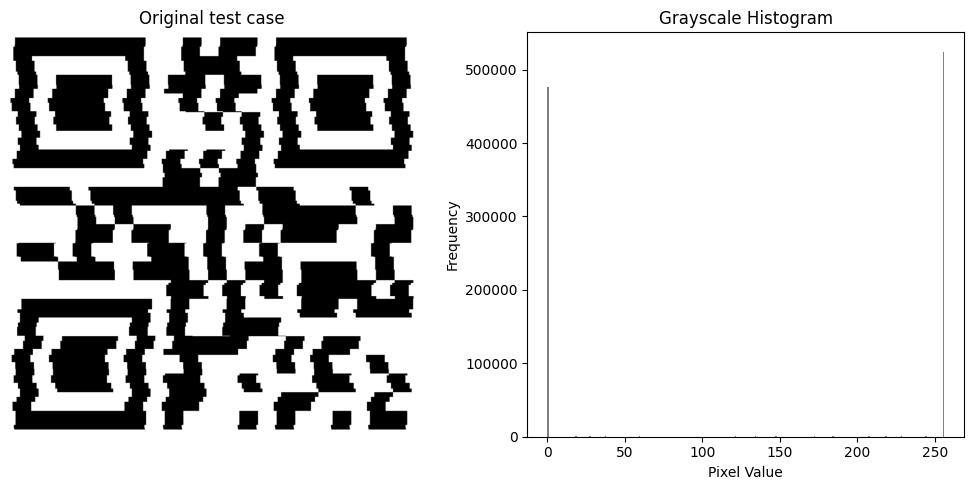

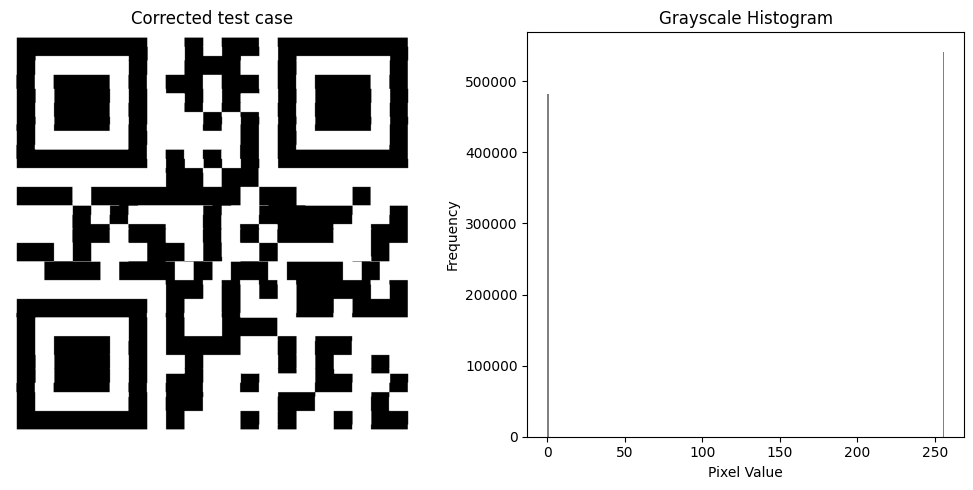

In [20]:
def tc05_preprocessing(original_img):
  #define tolerance
  t = 30

  img = original_img.copy()
  _, img = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  mask = np.full((img.shape[0], img.shape[1]), 255)
  h, w = img.shape[:2]

  first_from_left = 0
  first_from_right = 0
  # find first black pixel from the left
  b = False
  for i in range(h):
    if b :
      break
    for j in range(w):
      if img[i, j] == 0:
        first_from_left = j
        b = True
        break
    

  # find first black pixel from the right 
  b = False
  for i in range(h):
    if b :
      break
    for j in range(w-1, 0, -1):
      if img[i, j] == 0:
        first_from_right = j
        b = True
        break
    

  # calculate the left and right refrences
  qr_width = first_from_right-first_from_left
  left_ref = int((w-qr_width)/2)
  right_ref = left_ref+qr_width

  #print(f"sss: {first_from_left} {first_from_right}")

  # apply correction to each row
  for i in range(h):

    found_black_pixel = False

    # find left and right boundaries
    l_ptr = 0
    r_ptr = w-1

    while (img[i, l_ptr] == 255 or img[i, r_ptr] == 255) and (l_ptr < r_ptr):
      if img[i, l_ptr] == 255:
        l_ptr += 1
      else:
        found_black_pixel = True

      if img[i, r_ptr] == 255:
        r_ptr -= 1
      else:
        found_black_pixel = True

    #print(l_ptr)


    # correct if cross left refrence

    if (l_ptr<left_ref ) and found_black_pixel:
      shift_amount = left_ref - l_ptr
      # Shift row to the right -->
      mask[i][l_ptr+shift_amount:r_ptr+shift_amount] = img[i][l_ptr:r_ptr]

    elif (right_ref-r_ptr < t) and found_black_pixel:
      shift_amount = right_ref-r_ptr
      # Shift row to the right -->
      mask[i][l_ptr+shift_amount:r_ptr+shift_amount] = img[i][l_ptr:r_ptr]

    elif (r_ptr>right_ref ) and found_black_pixel:
      shift_amount = r_ptr - right_ref
      # Shift row to the left <--
      mask[i][l_ptr-shift_amount:r_ptr-shift_amount] = img[i][l_ptr:r_ptr]

    elif (l_ptr-left_ref < t ) and found_black_pixel:
      shift_amount = l_ptr-left_ref
      # Shift row to the left <--
      mask[i][l_ptr-shift_amount:r_ptr-shift_amount] = img[i][l_ptr:r_ptr]
    
    else:
      # Center the row
      center_of_the_row = int((r_ptr + l_ptr)/2)
      center_refrence = int((right_ref + left_ref)/2) 
      shift_amount = center_of_the_row - center_refrence
      mask[i][l_ptr-shift_amount:r_ptr-shift_amount] = img[i][l_ptr:r_ptr]

  printing_dict = {
    'Original test case': original_img,
    'Corrected test case': mask,
  }
  return printing_dict
 
 # load a grayscale image


original_img = cv2.imread('images/05-Caesar-cipher.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc05_preprocessing(original_img)

plot_all_needed_images(printing_dict)


### Test case 06

In [ ]:
# Testcase 6 #
def tc06_preprocessing(original_img):

    # Find Hough
    hough_lines_6 = get_hough(original_img)
    # Find the approximate Contour
    exact,appx = get_contour(hough_lines_6)
    # Draw approximate Contour
    cont_img = original_img.copy()
    if appx is not None:
        cv2.drawContours(cont_img, [appx], -1, (0, 0, 0), 4) 
    # Fitting the QR code into a square #
    # Find contour edge vertices
    bottom_left, top_left, top_right, bottom_right = appx.reshape(-1, 2)
    # Calculate new edge vertices positions
    top_left = [top_right[0], bottom_left[1]]
    bottom_right = [bottom_left[0], top_right[1]]
    target_verticies = np.array([bottom_left, top_left, top_right, bottom_right], dtype= np.float32)
    warped_image = shift_perspective(original_img, appx, target_verticies)
    
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'After Prespective shift' : warped_image
    }
    return printing_dict
    
img_6 = cv2.imread('./images/06-Railfence-cipher.png', cv2.IMREAD_GRAYSCALE)
dict_6 = tc06_preprocessing(img_6)
plot_all_needed_images(dict_6)

### Test case 07

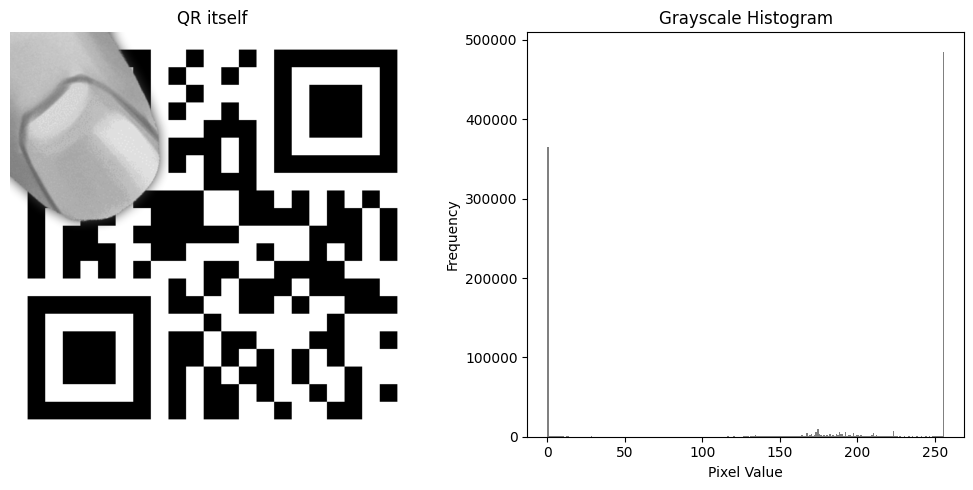

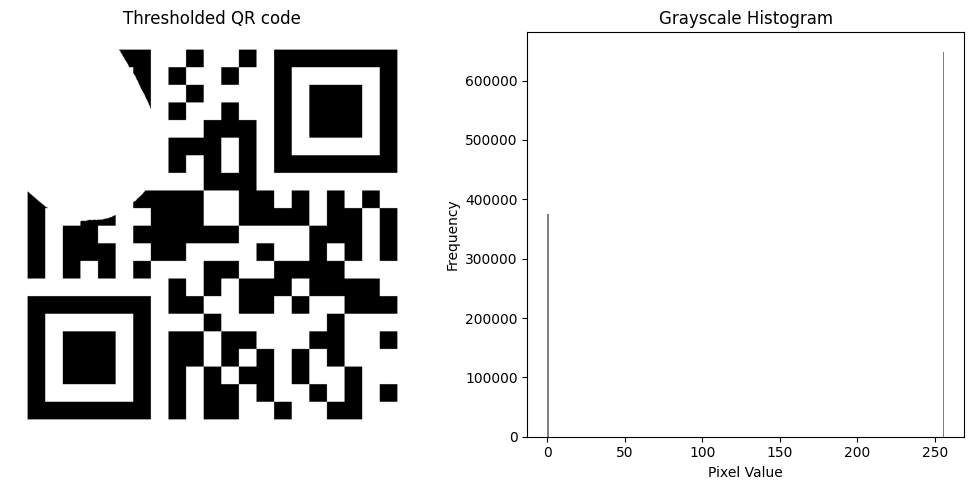

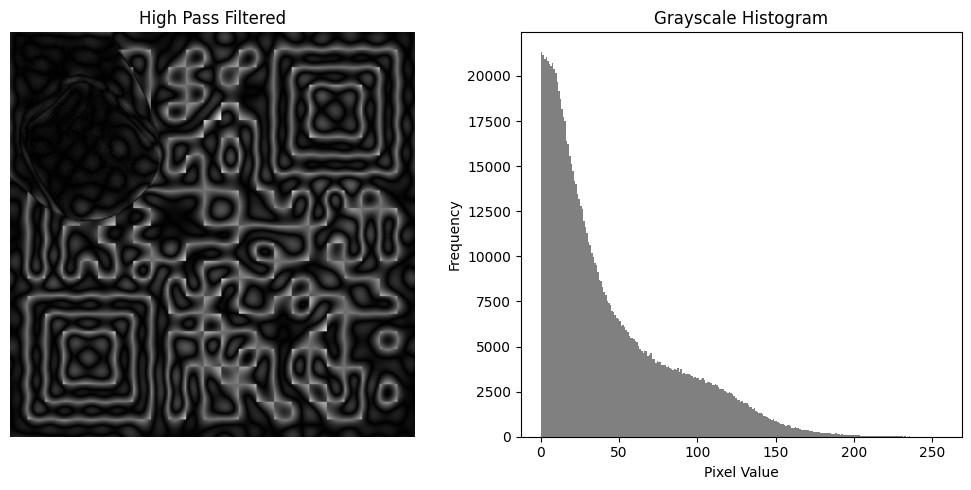

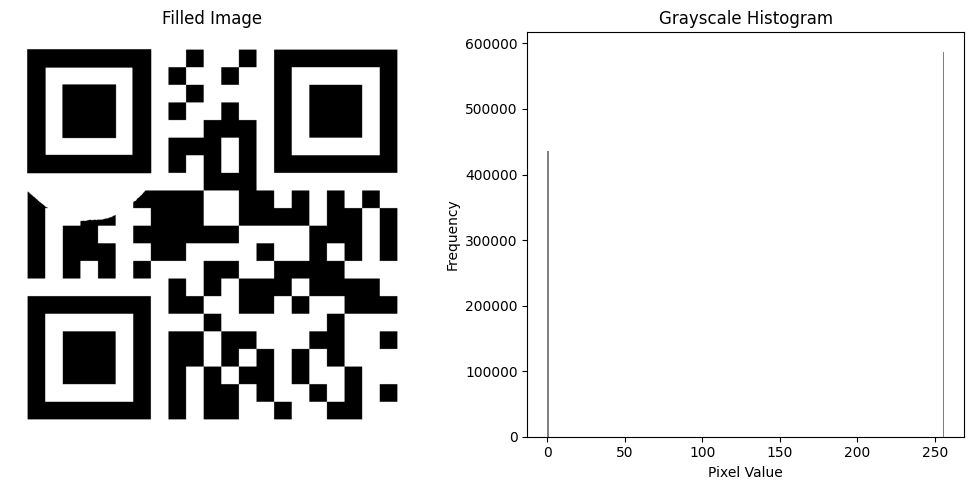

In [21]:
def fill_gaps_07(img):
    img_copy = img.copy()
    #! filling in the TOP LEFT FINDER PATTERN
    # filling the MIDDLE SQUARE
    pts = np.array([[131,264], [131, 131], [264, 131], [264, 264]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(img_copy, [pts], (0, 0, 0))

    # filling the LEFT OUTER LEG
    pts = np.array([[43,352], [43, 43], [88, 43], [88, 352]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(img_copy, [pts], (0, 0, 0))

    # filling the UPPER OUTER LEG
    pts = np.array([[43,88], [43, 43], [352, 43], [352, 88]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(img_copy, [pts], (0, 0, 0))

    # filling the RIGHT OUTER LEG
    pts = np.array([[306,352], [306, 43], [352, 43], [352, 352]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(img_copy, [pts], (0, 0, 0))

    # filling the BOTTOM OUTER LEG
    pts = np.array([[43,352], [43, 307], [352, 307], [352, 352]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(img_copy, [pts], (0, 0, 0))

    return img_copy

def tc07_preprocessing(image):

    # Calculate the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0,256])

    _, thresh_img = cv2.threshold(image, 90, 255, cv2.THRESH_BINARY)

    # Calculate the Fourier transform
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted)+500)

    # Apply high-pass filter
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    mask = np.ones((rows, cols), np.uint8)
    r = 15  # Radius of the circular mask
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
    mask[mask_area] = 0
    f_transform_shifted_filtered = f_transform_shifted * mask

    # Calculate the inverse Fourier transform
    f_transform_filtered = np.fft.ifftshift(f_transform_shifted_filtered)
    image_filtered = np.fft.ifft2(f_transform_filtered)
    image_filtered = np.abs(image_filtered)

    # Fill in the finder pattern for decoding
    image_filled = fill_gaps_07(thresh_img)

    printing_dict = {
        'QR itself': image,
        'Thresholded QR code': thresh_img,
        'High Pass Filtered': image_filtered,
        'Filled Image': image_filled
    }

    return printing_dict

# Load the image
image = cv2.imread('images/07-THE-MIGHTY-FINGER.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc07_preprocessing(image)

plot_all_needed_images(printing_dict)


### Test case 08

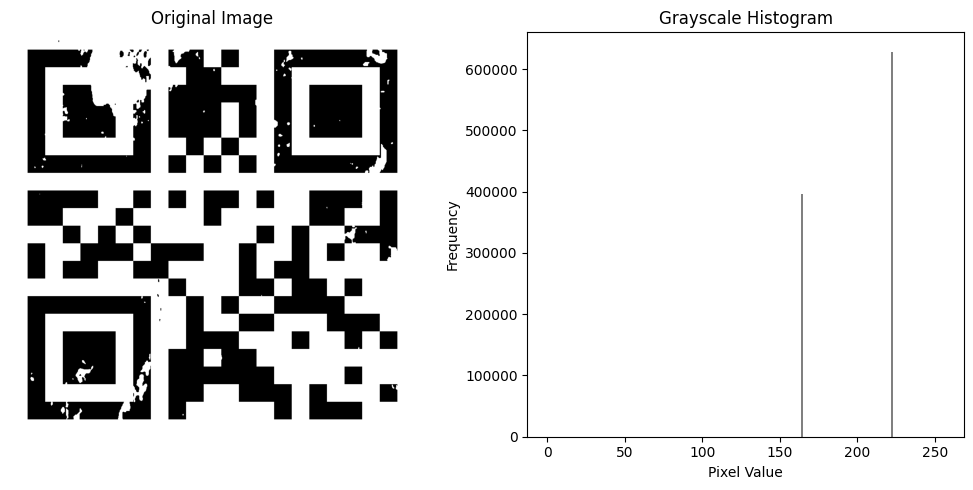

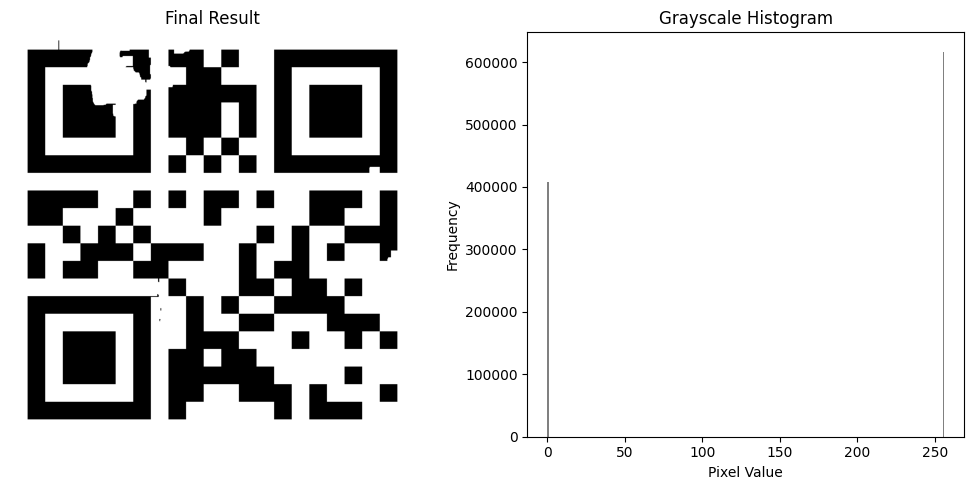

In [23]:
def tc08_preprocessing(img):
    # Find the unique pixel values
    unique_values = np.unique(img)
    #print(unique_values) # 164, 222

    # Apply thresholding
    ret, thresh = cv2.threshold(img, 170, 255, cv2.THRESH_BINARY)

    # Define the kernel for morphological operation
    kernel = np.ones((21,21),np.uint8)

    # Apply morphological closing , !!!!!!!!!!!!!!apply openning
    closing = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    printing_dict = {
        'Original Image': img,
        'Final Result': closing
    }

    return printing_dict


image = cv2.imread('images/08-Compresso-Espresso.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc08_preprocessing(image)

plot_all_needed_images(printing_dict)


### Test case 09

In [ ]:
def tc09_preprocessing(img):
    # Calculate the histogram
    hist = cv2.calcHist([img], [0], None, [256], [0,256])

    # Apply morphological opening (will be closing in this case) 

    # Create a kernel
    kernel = np.ones((17, 17), np.uint8)

    # Apply morphological opening
    processed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    #plt.imshow(processed_img, cmap='gray')

    # Apply Weiner deconvultion

    # Intialize the kernel 
    kernel_size = 3
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        kernel[i, i] = 1/(kernel_size**2)
    # kernel /= np.sum(kernel)

    # Pad the kernel to match the size of the blurred image
    padded_kernel = np.zeros_like(processed_img, dtype=np.float64)
    kernel_height, kernel_width = kernel.shape
    padded_kernel[:kernel_height, :kernel_width] = kernel

    # FT of the kernel
    ft_kernel = np.fft.fft2(padded_kernel)

    # FT of the image
    ft_image = np.fft.fft2(processed_img)

    # Apply Wiener deconvolution
    epsilon = 1e-8  # Small constant to avoid division by zero
    wiener_filter = np.conj(ft_kernel) / (np.abs(ft_kernel)**2 + epsilon)
    restored_image_fft = ft_image * wiener_filter
    restored_image = np.fft.ifft2(restored_image_fft).real

    # Clip the values to [0, 255] and convert to uint8
    restored_image = np.clip(restored_image, 0, 255).astype(np.uint8)

    # # Apply thresholding
    # ret, thresholded_spectrum = cv2.threshold(restored_image, 250, 255, cv2.THRESH_BINARY)

    # Apply median blurring
    blurred_image = cv2.medianBlur(restored_image, 5)

    kernel = np.ones((21,21),np.uint8)
    closing = cv2.morphologyEx(blurred_image, cv2.MORPH_OPEN, kernel)

    printing_dict = {
        'Original Image': img,
        'Processed Image': closing
    }

    return printing_dict

img = cv2.imread('images/09-My-phone-fell-while-taking-this-one-...-or-did-it.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc09_preprocessing(img)

plot_all_needed_images(printing_dict)


### Test case 10

In [ ]:
def contrast_stretching_and_thresholding(image):

    # Compute the minimum and maximum pixel values
    min_val = np.min(image)
    max_val = np.max(image)

    # Apply contrast stretching formula to each pixel
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255.0

    # Apply binary thresholding to make pixels either 0 or 255
    _, thresholded_img = cv2.threshold(stretched_image, 254, 255, cv2.THRESH_BINARY)

    return thresholded_img

def apply_closing(image, kernel_size):
    # Define the kernel for dilation and erosion
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply dilation
    dilated_image = cv2.dilate(image, kernel, iterations=1)

    # Apply erosion
    closed_image = cv2.erode(dilated_image, kernel, iterations=1)

    return closed_image

def fill_gaps_10(img):
    image_copy = img.copy()
    #! filling in the TOP LEFT FINDER PATTERN
    # filling the MIDDLE SQUARE
    pts = np.array([[127,127], [127, 264], [264, 264], [264, 127]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image_copy, [pts], (0, 0, 0))

    # filling the LEFT OUTER LEG
    pts = np.array([[42,352], [42, 45], [88, 45], [88, 352]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image_copy, [pts], (0, 0, 0))

    # filling the UPPER OUTER LEG
    pts = np.array([[42,88], [42, 45], [350, 45], [350, 88]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image_copy, [pts], (0, 0, 0))

    # filling the RIGHT OUTER LEG
    pts = np.array([[304,352], [304, 45], [350, 45], [350, 352]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image_copy, [pts], (0, 0, 0))

    # filling the BOTTOM OUTER LEG
    pts = np.array([[42,352], [42, 305], [350, 305], [350, 352]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image_copy, [pts], (0, 0, 0))

    #! filling in the TOP RIGHT FINDER PATTERN
    # filling the UPPER OUTER LEG
    pts = np.array([[657,88], [657, 45], [967, 45], [967, 88]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image_copy, [pts], (0, 0, 0))

    return image_copy

def tc10_preprocessing(img):
    # applying contrast stretching
    stretched_img = contrast_stretching_and_thresholding(img)
    closed_stretched_img = apply_closing(stretched_img, kernel_size=3)
    finalResult = fill_gaps_10(closed_stretched_img)

    printing_dict = {
        "Original Image": img,
        "Contrast Stretched and thresholded Image": stretched_img,
        "Closed Contrast Stretched Image": closed_stretched_img,
        "Final Result (Filled Gaps)": finalResult
    }

    return printing_dict


gone_with_the_wind_image_path = 'images/10-Gone-With-The-Wind.png'

# Read the image
img = cv2.imread(gone_with_the_wind_image_path, cv2.IMREAD_GRAYSCALE)

printing_dict = tc10_preprocessing(img)

plot_all_needed_images(printing_dict)

### Test case 11

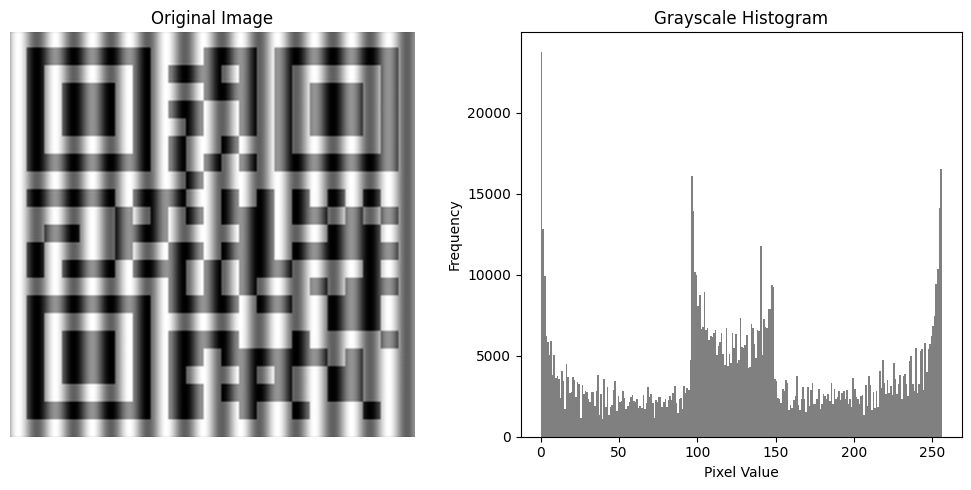

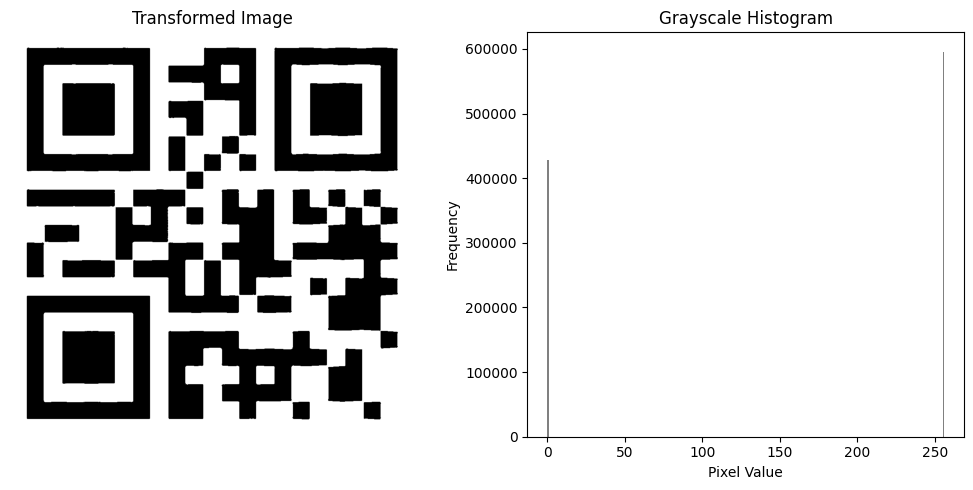

In [26]:
def tc11_preprocessing(img):
    # Compute fourier tranform of the image 
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # # View transform and zoom on the middle
    # magnitude_spectrum =  np.log(np.abs(f_transform_shifted) + 100)
    # plt.imshow(magnitude_spectrum, cmap='gray')

    # Create a filter to remove sinusoidal noise of frequency 11
    mask = np.ones_like(img)
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask[crow][ccol-11] = 0
    mask[crow][ccol+11] = 0
    # mask[crow][ccol-12] = 0
    # mask[crow][ccol+12] = 0


    # Apply the filter mask
    f_transform_shifted_filtered = f_transform_shifted * mask

    # # View transform and zoom on the middle
    # magnitude_spectrum_filtered =  np.log(np.abs(f_transform_shifted_filtered) + 100)
    # plt.imshow(magnitude_spectrum_filtered, cmap='gray')

    # Do inverse fourier transform
    fft_ifft_shift = np.fft.ifftshift(f_transform_shifted_filtered)
    imageThen = np.fft.ifft2(fft_ifft_shift)
    imageThen = np.abs(imageThen)
    #plt.imshow(imageThen, cmap='gray')

    # Apply thresholding
    ret, thresholded_spectrum = cv2.threshold(imageThen, 100, 255, cv2.THRESH_BINARY)

    printing_dict = {
        'Original Image': img,
        'Transformed Image': thresholded_spectrum
    }

    return printing_dict

image = cv2.imread('./images/11-weewooweewooweewoo.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc11_preprocessing(image)

plot_all_needed_images(printing_dict)

### Test case 12

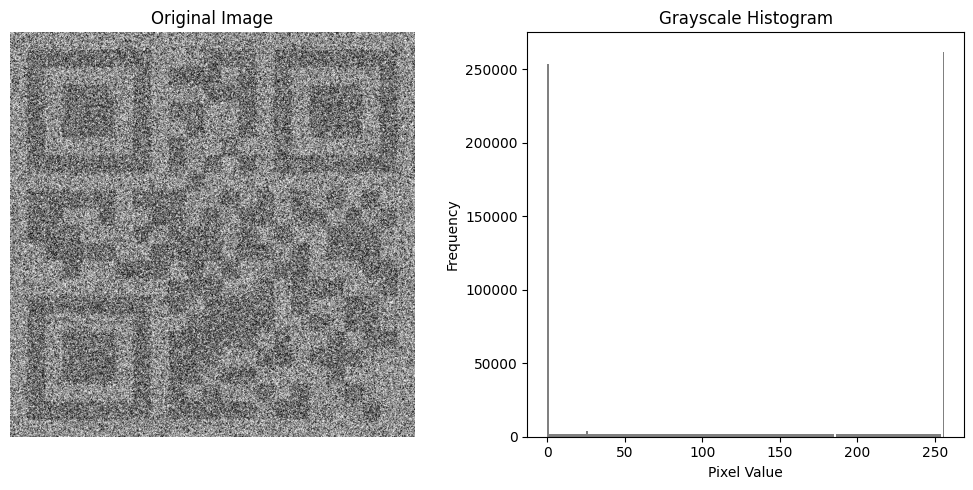

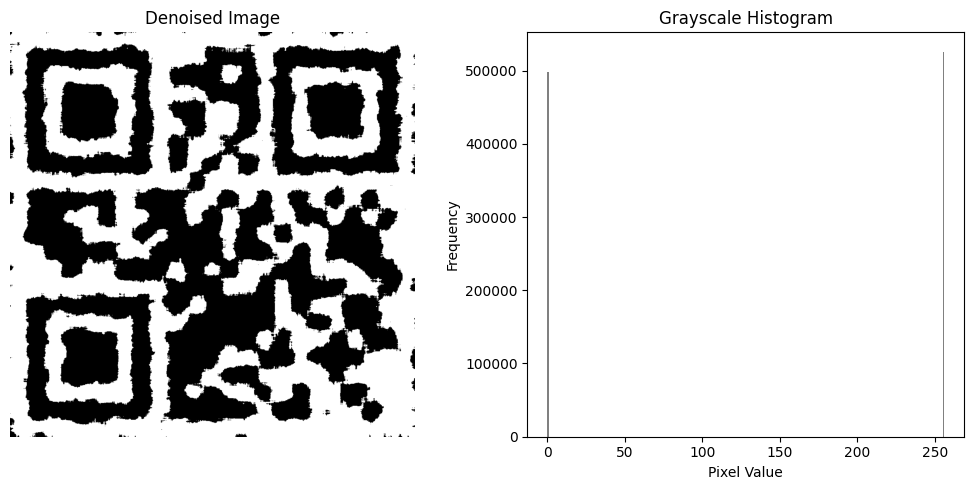

In [27]:
def remove_salt_and_pepper_noise(img):
    # Apply binary thresholding to make pixels either 0 or 255
    _, thresholded_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    # Apply custom median filtering
    filtered_image = cv2.medianBlur(thresholded_img, ksize=31)  # Apply median filter with ksize=1 (kernel size not used)

    return filtered_image

def tc12_preprocessing(img):
    denoised_image = remove_salt_and_pepper_noise(img)

    printing_dict = {
        'Original Image': img,
        'Denoised Image': denoised_image
    }

    return printing_dict


img = cv2.imread('images/12-mal7-w-felfel.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc12_preprocessing(img)

plot_all_needed_images(printing_dict)


### Test case 13

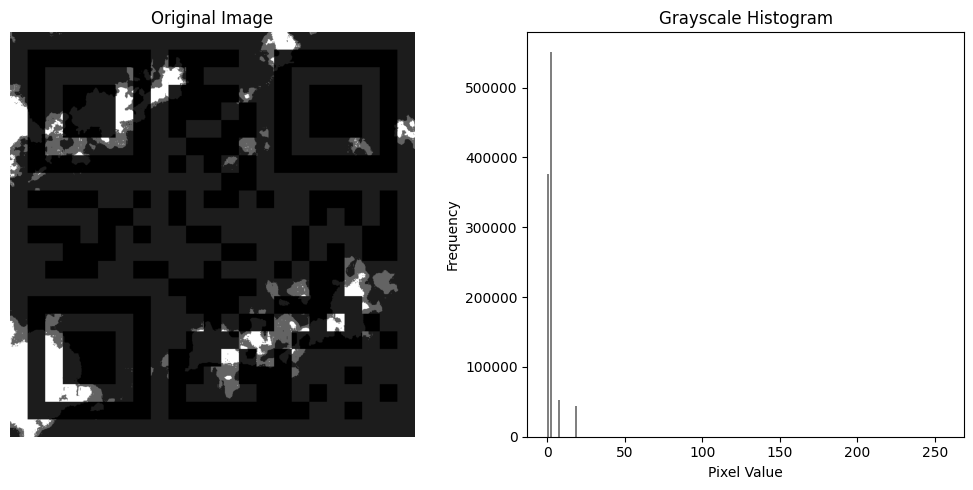

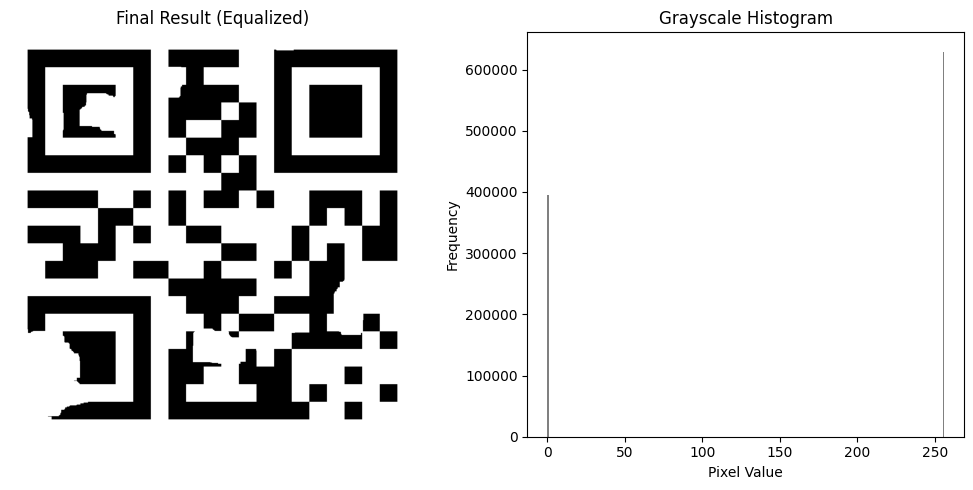

In [28]:
def tc13_preprocessing(img):
    # Calculate the histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])

    # Plot the histogram
    #plt.plot(hist, color='gray')

    # Apply histogram equalization
    equlaized_image = cv2.equalizeHist(img)

    # Calculate the new histogram
    hist = cv2.calcHist([equlaized_image], [0], None, [256], [0, 256])

    # Find the unique pixel values
    unique_values = np.unique(equlaized_image)

    # Print the unique pixel values
    #print("Unique pixel values:", unique_values) #0 217 238 255

    # Modify those values
    # 217->255 , 238->255
    #equlaized_image[equlaized_image == 255] = 0
    equlaized_image[equlaized_image == 217] = 255
    equlaized_image[equlaized_image == 238] = 255

    # Apply opening (equivelant to closing) 
    kernel = np.ones((41,41),np.uint8)
    closing = cv2.morphologyEx(equlaized_image, cv2.MORPH_OPEN, kernel)

    printing_dict = {
        'Original Image': img,
        'Final Result (Equalized)': closing
    }

    return printing_dict


image = cv2.imread('images/13-2el-noor-2ata3.png', cv2.IMREAD_GRAYSCALE)

printing_dict = tc13_preprocessing(image)

plot_all_needed_images(printing_dict)

### Test case 14

In [ ]:
# Testcase 14 #
def tc14_preprocessing(original_img):

    # Threshold the image to remove banana
    _, thresh_img = cv2.threshold(original_img, 90, 255, cv2.THRESH_BINARY)
    # Find Hough
    hough_lines_14 = get_hough(thresh_img)
    # Find the approximate Contour
    exact,appx = get_contour(hough_lines_14)
    # Draw approximate Contour
    cont_img = original_img.copy()
    if appx is not None:
        cv2.drawContours(cont_img, [appx], -1, (0, 0, 0), 4) 
    # Fitting the QR code into a square

    # Target verticies (Base image verticies)
    target_verticies = np.array([[967,42], [42,42], [42,967], [967,967]], dtype= np.float32)

    warped_image = shift_perspective(original_img, appx, target_verticies)

    # Apply thresholding
    _, thresh_shifted_img = cv2.threshold(warped_image, 60, 255, cv2.THRESH_BINARY)

    
    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img,
        'After Prespective shift' : thresh_shifted_img
    }
    return printing_dict
    
img_14 = cv2.imread('./images/14-BANANAAA!!!.png', cv2.IMREAD_GRAYSCALE)
dict_14 = tc14_preprocessing(img_14)
plot_all_needed_images(dict_14)

### Test case 15

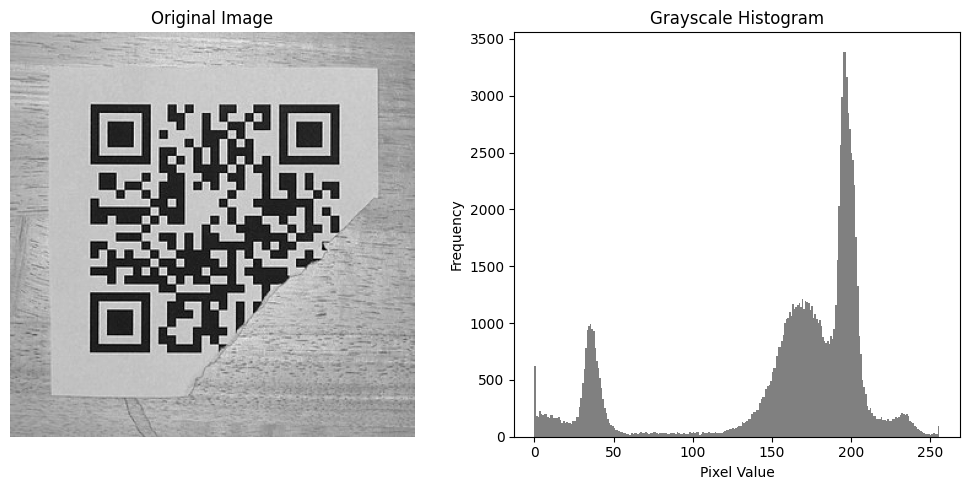

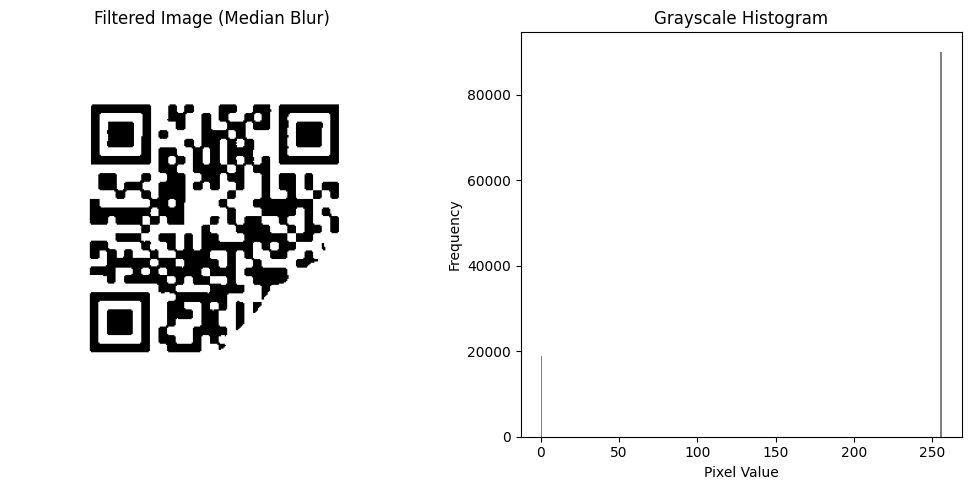

In [29]:
def tc15_preprocessing(image):
    _, thresholded_img = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)

    filtered_img = cv2.medianBlur(thresholded_img, 3)

    printing_dict = {
        'Original Image': image,
        'Filtered Image (Median Blur)': filtered_img
    }

    return printing_dict


img = cv2.imread('images/15-beast-mode-computer-vision-(this-one-is-from-wikipedia).jpg', cv2.IMREAD_GRAYSCALE)

printing_dict = tc15_preprocessing(img)

plot_all_needed_images(printing_dict)

### Test case 16

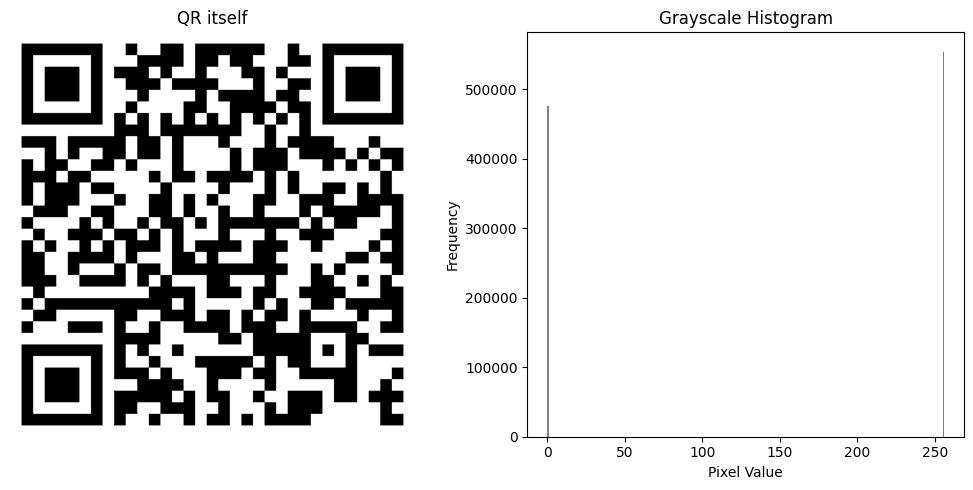

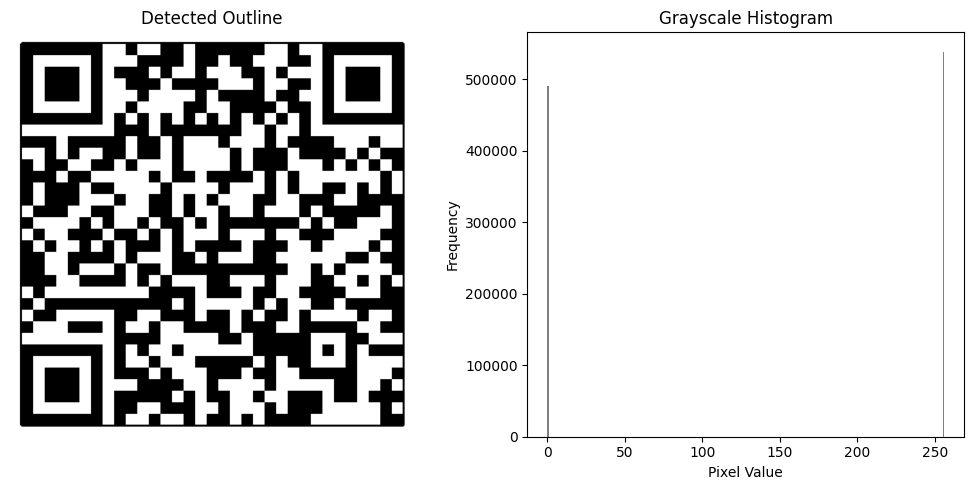

In [30]:
def tc16_preprocessing(original_img):
    
    # Find Hough
    hough_lines_16 = get_hough(original_img)
    # Find Contour
    exact,appx = get_contour(hough_lines_16)
    # Draw contour
    cont_img = original_img.copy()
    if exact is not None:
        cv2.drawContours(cont_img, [exact], -1, (0, 0, 0), 4) 

    # Construct the printing dictionary
    printing_dict = {
        'QR itself': original_img,
        'Detected Outline' : cont_img
    }
    return printing_dict
    
img_16 = cv2.imread('images/16-V3-QR-Code...-can-you-do-it.png', cv2.IMREAD_GRAYSCALE)
dict_16 = tc16_preprocessing(img_16)
plot_all_needed_images(dict_16)